# comparaison de metaheuristique

In [3]:
import random
seed = random.randint(0, 100000)
print(f"Seed : {seed}")

Seed : 3311


In [4]:
import matplotlib.pyplot as plt
import random
import networkx as nx

def generate_graph(n, weight_range=(1, 100), restricted_edge=0.1, seed=None):
    if seed is not None:
        random.seed(seed)
        
    G = nx.complete_graph(n)

    # Ajouter des poids aléatoires aux arêtes
    for u, v in G.edges():
        time, distance, cost = generate_weight(restricted_edge, weight_range)
        G[u][v]['time'] = time
        G[u][v]['distance'] = distance
        G[u][v]['cost'] = cost
    
    return G

In [5]:
def plot_vrp_solution(graph, routes, depot):
    #dessiner le graphe
    pos = nx.spring_layout(graph, seed=42)  
    colors = ['red', 'blue', 'green', 'orange', 'purple', 'brown', 'pink', 'gray'] 
    plt.figure(figsize=(12, 10))
    nx.draw_networkx_nodes(graph, pos, node_size=800, node_color='lightblue')
    nx.draw_networkx_labels(graph, pos, font_size=12, font_color='black')
    
    #dessiner les arêtes
    for i, route in enumerate(routes):
        color = colors[i % len(colors)]  
        edges = [(route[j], route[j + 1]) for j in range(len(route) - 1)]
        nx.draw_networkx_edges(graph, pos, edgelist=edges, width=2.5, edge_color=color, label=f'Camion {i + 1}')
    nx.draw_networkx_nodes(graph, pos, nodelist=[depot], node_size=1000, node_color='yellow', label='Dépôt')
    plt.title("Solution VRP avec routes colorées", fontsize=16)
    plt.legend()
    plt.show()

In [6]:
def generate_weight(restricted_edge, weight_range):
    if random.random() < restricted_edge: time = 999
    else: time = random.randint(*weight_range)
    if random.random() < restricted_edge: distance = 999
    else: distance = random.randint(*weight_range)
    if random.random() < restricted_edge: cost = 999
    else: cost = random.randint(*weight_range)
    return time, distance, cost

def generate_graph(n, weight_range=(1, 100), restricted_edge=0.1, seed=None):
    if seed is not None:
        random.seed(seed)
        
    G = nx.complete_graph(n)

    # Ajouter des poids aléatoires aux arêtes
    for u, v in G.edges():
        time, distance, cost = generate_weight(restricted_edge, weight_range)
        G[u][v]['time'] = time
        G[u][v]['distance'] = distance
        G[u][v]['cost'] = cost
    
    return G


In [7]:
from tqdm import tqdm
import pandas as pd
import time
from ipywidgets import IntProgress
from IPython.display import display

def ant_colony_vrp_fast(graph, depot, max_nodes=5, num_ants=10, num_iterations=50, alpha=1, beta=2, evaporation_rate=0.5, pheromone_init=1.0):

    pheromones = {edge: pheromone_init for edge in graph.edges}
    best_routes = None
    best_cost = float('inf')
    for iteration in range(num_iterations):
        for ant in range(num_ants):
            unvisited = set(graph.nodes)
            unvisited.remove(depot)
            routes = []
            total_cost = 0

            while unvisited:
                current_route = [depot]
                current_node = depot

                while unvisited and len(current_route) - 1 < max_nodes: 
                    neighbors = [n for n in graph.neighbors(current_node) if n in unvisited]
                    if not neighbors:
                        break

                    probabilities = []
                    for neighbor in neighbors:
                        edge = (current_node, neighbor) if (current_node, neighbor) in pheromones else (neighbor, current_node)
                        pheromone = pheromones[edge]
                        distance = graph[current_node][neighbor]['distance']
                        probabilities.append((neighbor, (pheromone ** alpha) * ((1 / distance) ** beta)))

                    if not probabilities:
                        break

                    total_prob = sum(prob[1] for prob in probabilities)
                    next_node = random.choices(
                        [node for node, _ in probabilities],
                        [prob / total_prob for _, prob in probabilities]
                    )[0]

                    current_route.append(next_node)
                    total_cost += graph[current_node][next_node]['distance']
                    unvisited.remove(next_node)
                    current_node = next_node

                if current_node != depot:
                    current_route.append(depot)
                    total_cost += graph[current_node][depot]['distance']

                routes.append(current_route)

            if total_cost < best_cost:
                best_cost = total_cost
                best_routes = routes

        for edge in pheromones:
            pheromones[edge] *= (1 - evaporation_rate)

        for route in best_routes:
            for i in range(len(route) - 1):
                edge = (route[i], route[i + 1]) if (route[i], route[i + 1]) in pheromones else (route[i + 1], route[i])
                pheromones[edge] += 1 / best_cost

    return best_routes, best_cost


# Paramètres à tester
graph_sizes = [5, 10, 15, 20, 30]
num_ants_list = [5, 10, 20, 30, 50]
num_iterations_list = [50, 100, 200, 500]
alpha_list = [ 1, 2]
beta_list = [ 2, 5]
evaporation_rate_list = [0.3, 0.5]
pheromone_init_list = [ 1.0, 2.0]

results = []
execution_times = []

# Calcul du nombre total de tests
nb_tests = (
    len(graph_sizes)
    * len(num_ants_list)
    * len(num_iterations_list)
    * len(alpha_list)
    * len(beta_list)
    * len(evaporation_rate_list)
    * len(pheromone_init_list)
)

# Initialiser la barre de progression générale
bar = IntProgress(min=0, max=nb_tests, layout={"width": "100%"})
display(bar)

# Boucle sur tous les paramètres
for size in tqdm(graph_sizes, desc="Graph Sizes"):
    G = generate_graph(size, weight_range=(1, 100), restricted_edge=0.1, seed=seed)
    
    for num_ants in tqdm(num_ants_list, desc="Num Ants", leave=False):
        for num_iterations in tqdm(num_iterations_list, desc="Num Iterations", leave=False):
            for alpha in alpha_list:
                for beta in beta_list:
                    for evaporation_rate in evaporation_rate_list:
                        for pheromone_init in pheromone_init_list:
                            start_time = time.time()
                            best_routes, best_cost = ant_colony_vrp_fast(
                                G, depot=0, max_nodes=4, num_ants=num_ants, num_iterations=num_iterations,
                                alpha=alpha, beta=beta, evaporation_rate=evaporation_rate, pheromone_init=pheromone_init
                            )
                            end_time = time.time()
                            execution_time = end_time - start_time
                            
                            execution_times.append((
                                size, num_ants, num_iterations, alpha, beta, evaporation_rate, pheromone_init, execution_time
                            ))
                            results.append((
                                size, num_ants, num_iterations, alpha, beta, evaporation_rate, pheromone_init, best_cost
                            ))
                            
                            bar.value += 1  # mettre à jour la barre

# Cacher la barre de progression à la fin
bar.close()

# Convertir les résultats en DataFrame pour analyse
columns = ["Graph Size", "Num Ants", "Num Iterations", "Alpha", "Beta", "Evaporation Rate", "Pheromone Init", "Best Cost"]
results_df = pd.DataFrame(results, columns=columns)

execution_columns = ["Graph Size", "Num Ants", "Num Iterations", "Alpha", "Beta", "Evaporation Rate", "Pheromone Init", "Execution Time"]
execution_times_df = pd.DataFrame(execution_times, columns=execution_columns)

# -----------------
# EXEMPLES DE PLOTS
# -----------------

# Impact de Alpha sur le coût
plt.figure(figsize=(12, 8))
for alpha in alpha_list:
    subset = results_df[results_df["Alpha"] == alpha]
    plt.plot(
        subset["Num Iterations"], 
        subset["Best Cost"], 
        marker='o', 
        label=f"Alpha {alpha}"
    )
plt.xlabel("Num Iterations")
plt.ylabel("Best Cost")
plt.title("Impact de Alpha sur le coût optimal")
plt.legend()
plt.grid()
plt.show()

# Impact de Beta sur le coût
plt.figure(figsize=(12, 8))
for beta in beta_list:
    subset = results_df[results_df["Beta"] == beta]
    plt.plot(
        subset["Num Iterations"], 
        subset["Best Cost"], 
        marker='o', 
        label=f"Beta {beta}"
    )
plt.xlabel("Num Iterations")
plt.ylabel("Best Cost")
plt.title("Impact de Beta sur le coût optimal")
plt.legend()
plt.grid()
plt.show()

# (Tu peux faire des plots similaires pour evaporation_rate, pheromone_init, execution_time, etc.)



ModuleNotFoundError: No module named 'tqdm'

In [ ]:
print("fefe",results_df)

fefe    Graph Size  Num Ants  Num Iterations  Alpha  Beta  Evaporation Rate  \
0           5         5              50      1     2               0.3   
1           5         5              50      1     2               0.3   
2           5         5              50      1     2               0.5   
3           5         5              50      1     2               0.5   
4           5         5              50      1     5               0.3   

   Pheromone Init  Best Cost  
0             1.0        255  
1             2.0        255  
2             1.0        255  
3             2.0        255  
4             1.0        255  


In [ ]:
print("temp",execution_times)

temp [(5, 5, 50, 1, 2, 0.3, 1.0, 0.02499985694885254), (5, 5, 50, 1, 2, 0.3, 2.0, 0.015996456146240234), (5, 5, 50, 1, 2, 0.5, 1.0, 0.010008573532104492), (5, 5, 50, 1, 2, 0.5, 2.0, 0.04480457305908203), (5, 5, 50, 1, 5, 0.3, 1.0, 0.016998767852783203), (5, 5, 50, 1, 5, 0.3, 2.0, 0.01699995994567871), (5, 5, 50, 1, 5, 0.5, 1.0, 0.022529125213623047), (5, 5, 50, 1, 5, 0.5, 2.0, 0.012518167495727539), (5, 5, 50, 2, 2, 0.3, 1.0, 0.02200031280517578), (5, 5, 50, 2, 2, 0.3, 2.0, 0.019002199172973633), (5, 5, 50, 2, 2, 0.5, 1.0, 0.010989665985107422), (5, 5, 50, 2, 2, 0.5, 2.0, 0.025006771087646484), (5, 5, 50, 2, 5, 0.3, 1.0, 0.011517047882080078), (5, 5, 50, 2, 5, 0.3, 2.0, 0.009002447128295898), (5, 5, 50, 2, 5, 0.5, 1.0, 0.008995532989501953), (5, 5, 50, 2, 5, 0.5, 2.0, 0.009003162384033203), (5, 5, 100, 1, 2, 0.3, 1.0, 0.01900315284729004), (5, 5, 100, 1, 2, 0.3, 2.0, 0.018998146057128906), (5, 5, 100, 1, 2, 0.5, 1.0, 0.017008543014526367), (5, 5, 100, 1, 2, 0.5, 2.0, 0.0193924903869628

In [ ]:
common_cols = ["Graph Size", "Num Ants", "Num Iterations", "Alpha", "Beta", "Evaporation Rate", "Pheromone Init"]
merged_df = pd.merge(results_df, execution_times_df, on=common_cols)

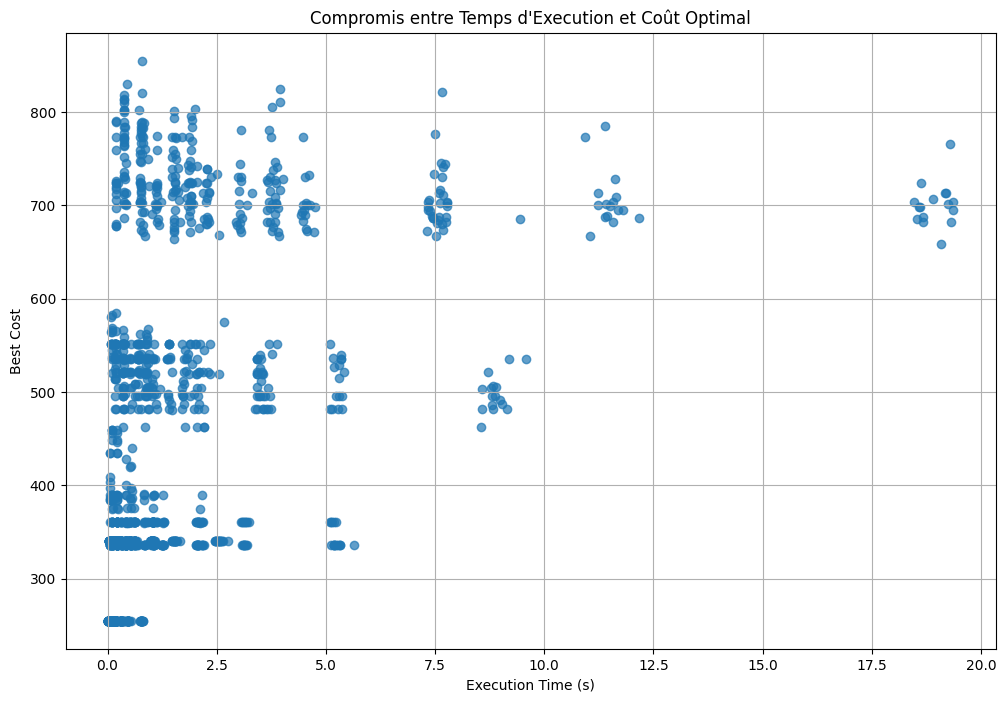

In [ ]:
plt.figure(figsize=(12, 8))
plt.scatter(
    merged_df["Execution Time"], 
    merged_df["Best Cost"], 
    alpha=0.7
)
plt.xlabel("Execution Time (s)")
plt.ylabel("Best Cost")
plt.title("Compromis entre Temps d'Execution et Coût Optimal")
plt.grid(True)
plt.show()


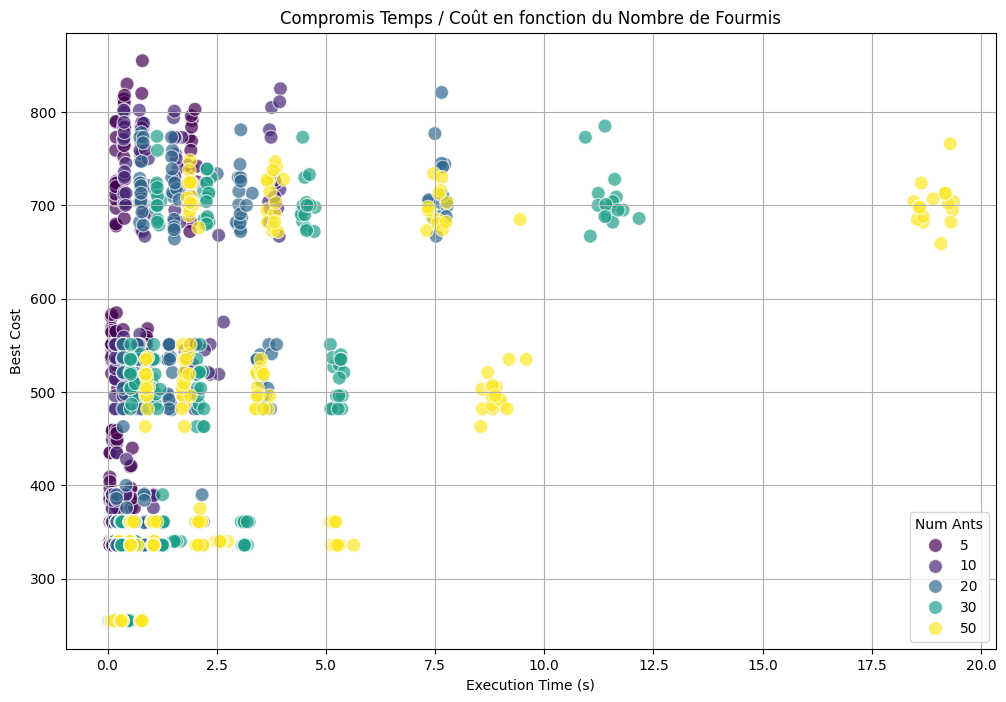

In [ ]:
import seaborn as sns

plt.figure(figsize=(12, 8))
sns.scatterplot(
    data=merged_df,
    x="Execution Time",
    y="Best Cost",
    hue="Num Ants",  # ou "Alpha", "Beta", etc.
    palette="viridis",
    s=100,
    alpha=0.7
)
plt.xlabel("Execution Time (s)")
plt.ylabel("Best Cost")
plt.title("Compromis Temps / Coût en fonction du Nombre de Fourmis")
plt.legend(title="Num Ants")
plt.grid(True)
plt.show()


In [ ]:
# 1. Fusion des résultats
common_cols = ["Graph Size", "Num Ants", "Num Iterations", "Alpha", "Beta", "Evaporation Rate", "Pheromone Init"]
merged_df = pd.merge(results_df, execution_times_df, on=common_cols)

# 2. Normalisation du coût et du temps
merged_df["Norm Best Cost"] = (merged_df["Best Cost"] - merged_df["Best Cost"].min()) / (merged_df["Best Cost"].max() - merged_df["Best Cost"].min())
merged_df["Norm Execution Time"] = (merged_df["Execution Time"] - merged_df["Execution Time"].min()) / (merged_df["Execution Time"].max() - merged_df["Execution Time"].min())

# 3. Calcul du score de compromis
a = 0.7  # Poids du coût
b = 0.3  # Poids du temps
merged_df["Score"] = a * merged_df["Norm Best Cost"] + b * merged_df["Norm Execution Time"]

# 4. Trouver la meilleure config pour chaque taille de graphe
best_configs = merged_df.loc[merged_df.groupby("Graph Size")["Score"].idxmin()]

# 5. Calculer la moyenne et l'écart-type des Execution Time pour chaque Graph Size
execution_stats = merged_df.groupby("Graph Size")["Execution Time"].agg(["mean", "std"]).reset_index()
execution_stats.rename(columns={"mean": "Execution Time Mean", "std": "Execution Time Std"}, inplace=True)

# 6. Fusionner avec le tableau final
best_configs = pd.merge(best_configs, execution_stats, on="Graph Size")

# 7. Afficher le tableau proprement
best_configs_display = best_configs[
    [
        "Graph Size", "Num Ants", "Num Iterations", "Alpha", "Beta",
        "Evaporation Rate", "Pheromone Init",
        "Best Cost", "Execution Time", "Execution Time Mean", "Execution Time Std", "Score"
    ]
].sort_values(by="Graph Size")

display(best_configs_display)


Graph Size  Num Ants  Num Iterations  Alpha  Beta  Evaporation Rate  \
0           5         5              50      2     5               0.5   
1          10         5              50      2     5               0.3   
2          15         5              50      1     5               0.3   
3          20        20              50      1     2               0.3   
4          30        10             100      2     2               0.3   

   Pheromone Init  Best Cost  Execution Time  Execution Time Mean  \
0             1.0        255        0.008996             0.163109   
1             2.0        340        0.026968             0.505451   
2             1.0        336        0.052992             1.031463   
3             2.0        463        0.357901             1.752552   
4             2.0        667        0.853701             3.737325   

   Execution Time Std     Score  
0            0.185528  0.000000  
1            0.608071  0.099445  
2            1.246512  0.095182  
3            2.113350  0.248074  
4            4.526065  0.493758

In [ ]:
# 1. Fusionner résultats et temps d'exécution
common_cols = ["Graph Size", "Num Ants", "Num Iterations", "Alpha", "Beta", "Evaporation Rate", "Pheromone Init"]
merged_df = pd.merge(results_df, execution_times_df, on=common_cols)

# 2. Calculer la moyenne et l'écart-type par Graph Size
execution_stats = merged_df.groupby("Graph Size")["Execution Time"].agg(["mean", "std"]).reset_index()
execution_stats.rename(columns={"mean": "Execution Time Mean", "std": "Execution Time Std"}, inplace=True)

# 3. Remettre les moyennes/écart-type dans merged_df (via merge)
full_df = pd.merge(merged_df, execution_stats, on="Graph Size")

# 4. Ordonner joliment
full_df = full_df[
    [
        "Graph Size", "Num Ants", "Num Iterations", "Alpha", "Beta",
        "Evaporation Rate", "Pheromone Init",
        "Best Cost", "Execution Time", "Execution Time Mean", "Execution Time Std"
    ]
]

# 5. Trier pour que les tailles soient groupées
full_df = full_df.sort_values(by=["Graph Size", "Best Cost", "Execution Time"])

# 6. Afficher joliment
from IPython.display import display

display(full_df.style.set_properties(**{'text-align': 'center'}).set_table_styles(
    [{'selector': 'th', 'props': [('text-align', 'center')]}]
))

In [ ]:
# 1. Fusionner résultats et temps d'exécution
common_cols = ["Graph Size", "Num Ants", "Num Iterations", "Alpha", "Beta", "Evaporation Rate", "Pheromone Init"]
merged_df = pd.merge(results_df, execution_times_df, on=common_cols)

# 2. Calculer la moyenne et l'écart-type par taille de graphe
execution_stats = merged_df.groupby("Graph Size")["Execution Time"].agg(["mean", "std"]).reset_index()
execution_stats.rename(columns={"mean": "Execution Time Mean", "std": "Execution Time Std"}, inplace=True)

# 3. Remettre les moyennes/écart-type dans merged_df
full_df = pd.merge(merged_df, execution_stats, on="Graph Size")

# 4. Supprimer la colonne "Num Iterations"
full_df = full_df.drop(columns=["Num Iterations"])

# 5. Réordonner les colonnes
full_df = full_df[
    [
        "Graph Size", "Num Ants", "Alpha", "Beta",
        "Evaporation Rate", "Pheromone Init",
        "Best Cost", "Execution Time", "Execution Time Mean", "Execution Time Std"
    ]
]

# 6. Trier proprement
full_df = full_df.sort_values(by=["Graph Size", "Best Cost", "Execution Time"])

# 7. Afficher
from IPython.display import display

display(full_df.style.set_properties(**{'text-align': 'center'}).set_table_styles(
    [{'selector': 'th', 'props': [('text-align', 'center')]}]
))


Graph Size	Num Ants	Alpha	Beta	Evaporation Rate	Pheromone Init	Best Cost	Execution Time	Execution Time Mean	Execution Time Std

671	    15	5	2	5	0.500000	2.000000	459	0.107538	1.031463	1.246512
660	    15	5	1	5	0.300000	1.000000	459	0.108956	1.031463	1.246512
669	    15	5	2	5	0.300000	2.000000	459	0.109999	1.031463	1.246512
684	    15	5	2	5	0.300000	1.000000	459	

nombre de fourmis: 5     alpha:2    beta: 2 ou 3 ou 4 ou 5      evaportation_rate:0.3 0.4 ou 0.5        pheromone_init:1 ou 1.5 ou 2


1151	20	20	2	5	0.500000	2.000000	551	3.871218	1.752552	2.113350
1206	20	30	1	5	0.500000	1.000000	551	5.100497	1.752552	2.113350
1002	20	5	2	2	0.500000	1.000000	552	0.370081	1.752552	2.113350
1020	20	5	2	5	0.300000	1.000000	556	0.899049	1.752552	2.113350
1050	20	10	2	2	0.500000	1.000000	559	0.370115	1.752552	2.113350
1021	20	5	2	5	0.300000	2.000000	559	0.895206	1.752552	2.113350
1067	20	10	2	2	0.500000	2.000000	562	0.739748	1.752552	2.113350
1008	20	5	1	2	0.300000	1.000000	562	0.889388	1.752552	2.113350



962	    20	5	1	2	0.500000	1.000000	564	0.090571	1.752552	2.113350
971	    20	5	2	2	0.500000	2.000000	564	0.096328	1.752552	2.113350
984	    20	5	2	2	0.300000	1.000000	565	0.192118	1.752552	2.113350
968	    20	5	2	2	0.300000	1.000000	566	0.092519	1.752552	2.113350
995	    20	5	1	2	0.500000	2.000000	567	0.356605	1.752552	2.113350
101	    20	5	2	2	0.500000	2.000000	568	0.916095	1.752552	2.113350
967	    20	5	1	5	0.500000	2.000000	569	0.092520	1.752552	2.113350
108	    20	10	2	2	0.500000	1.000000	575	2.655714	1.752552	2.113350
963	    20	5	1	2	0.500000	2.000000	580	0.089546	1.752552	2.113350
970	    20	5	2	2	0.500000	1.000000	583	0.091784	1.752552	2.113350
986	    20	5	2	2	0.500000	1.000000	585	0.202040	1.752552	2.113350



1398	30	10	1	5	0.500000	1.000000	805	3.757667	3.737325	4.526065
1304	30	5	2	2	0.300000	1.000000	810	0.384166	3.737325	4.526065
1404	30	10	2	5	0.300000	1.000000	811	3.941082	3.737325	4.526065
1298	30	5	1	2	0.500000	1.000000	813	0.376551	3.737325	4.526065
1303	30	5	1	5	0.500000	2.000000	814	0.375933	3.737325	4.526065
1310	30	5	2	5	0.500000	1.000000	818	0.387330	3.737325	4.526065
1318	30	5	1	5	0.500000	1.000000	820	0.784704	3.737325	4.526065
1465	30	20	2	2	0.300000	2.000000	821	7.648743	3.737325	4.526065
1402	30	10	2	2	0.500000	1.000000	825	3.959192	3.737325	4.526065
1307	30	5	2	2	0.500000	2.000000	830	0.446937	3.737325	4.526065
1327	30	5	2	5	0.500000	2.000000	855	0.798146	3.737325	4.526065


In [ ]:
# Paramètres précis à tester
graph_sizes = [5, 10, 15, 20, 30]  # comme avant
num_ants = 5
alpha = 2
beta_list = [2, 3, 4, 5]
evaporation_rate = 0.5
pheromone_init_list = [1.0, 1.5, 2.0]
num_iterations_list = [50, 100, 200, 500]  # Tu avais encore ça avant, je garde, à confirmer si tu veux le fixer aussi

# Pour stocker
results_precise = []
execution_times_precise = []

# Nouvelle barre de progression
nb_tests_precise = (
    len(graph_sizes) 
    * len(beta_list) 
    * len(pheromone_init_list) 
    * len(num_iterations_list)
)

bar_precise = IntProgress(min=0, max=nb_tests_precise, layout={"width": "100%"})
display(bar_precise)

# Boucle
for size in tqdm(graph_sizes, desc="Graph Sizes (precise)"):
    G = generate_graph(size, weight_range=(1, 100), restricted_edge=0.1, seed=seed)
    
    for beta in tqdm(beta_list, desc="Beta Values", leave=False):
        for pheromone_init in pheromone_init_list:
            for num_iterations in tqdm(num_iterations_list, desc="Num Iterations", leave=False):
                start_time = time.time()
                best_routes, best_cost = ant_colony_vrp_fast(
                    G, depot=0, max_nodes=4, num_ants=num_ants, num_iterations=num_iterations,
                    alpha=alpha, beta=beta, evaporation_rate=evaporation_rate, pheromone_init=pheromone_init
                )
                end_time = time.time()
                execution_time = end_time - start_time
                
                execution_times_precise.append((
                    size, num_ants, alpha, beta, evaporation_rate, pheromone_init, num_iterations, execution_time
                ))
                results_precise.append((
                    size, num_ants, alpha, beta, evaporation_rate, pheromone_init, num_iterations, best_cost
                ))
                
                bar_precise.value += 1  # Update progress bar

# Cacher la barre à la fin
bar_precise.close()

# Convertir en DataFrame
columns_precise = ["Graph Size", "Num Ants", "Alpha", "Beta", "Evaporation Rate", "Pheromone Init", "Num Iterations", "Best Cost"]
results_precise_df = pd.DataFrame(results_precise, columns=columns_precise)

execution_columns_precise = ["Graph Size", "Num Ants", "Alpha", "Beta", "Evaporation Rate", "Pheromone Init", "Num Iterations", "Execution Time"]
execution_times_precise_df = pd.DataFrame(execution_times_precise, columns=execution_columns_precise)


IntProgress(value=0, layout=Layout(width='100%'), max=240)

Graph Sizes (precise):   0%|          | 0/5 [00:00<?, ?it/s]



































Graph Sizes (precise):  20%|██        | 1/5 [00:02<00:10,  2.68s/it]






































Graph Sizes (precise):  40%|████      | 2/5 [00:09<00:14,  4.96s/it]


















































Graph Sizes (precise):  60%|██████    | 3/5 [00:21<00:16,  8.11s/it]




































































Graph Sizes (precise):  80%|████████  | 4/5 [00:41<00:12, 12.96s/it]







































































Graph Sizes (precise): 100%|██████████| 5/5 [01:24<00:00, 16.81s/it]


In [ ]:
# Joindre les deux DataFrames
merged_precise = pd.merge(
    results_precise_df.drop(columns=["Num Iterations"]),
    execution_times_precise_df.drop(columns=["Num Iterations"]),
    on=["Graph Size", "Num Ants", "Alpha", "Beta", "Evaporation Rate", "Pheromone Init"]
)

# Grouper pour calculer moyenne et écart-type
summary_precise = merged_precise.groupby(["Graph Size", "Beta", "Pheromone Init"]).agg({
    "Best Cost": "mean",
    "Execution Time": ["mean", "std"]
}).reset_index()

# Renommer proprement
summary_precise.columns = ["Graph Size", "Beta", "Pheromone Init", "Mean Best Cost", "Mean Execution Time", "Std Execution Time"]

# Afficher joliment
for size in sorted(summary_precise["Graph Size"].unique()):
    display(summary_precise[summary_precise["Graph Size"] == size])
    print("\n")


Graph Size  Beta  Pheromone Init  Mean Best Cost  Mean Execution Time  \
0            5     2             1.0           255.0             0.054952   
1            5     2             1.5           255.0             0.053260   
2            5     2             2.0           255.0             0.056144   
3            5     3             1.0           255.0             0.043510   
4            5     3             1.5           255.0             0.074740   
5            5     3             2.0           255.0             0.042253   
6            5     4             1.0           255.0             0.042510   
7            5     4             1.5           255.0             0.043658   
8            5     4             2.0           255.0             0.046529   
9            5     5             1.0           255.0             0.071091   
10           5     5             1.5           255.0             0.039511   
11           5     5             2.0           255.0             0.040759   

    Std Execution Time  
0             0.052175  
1             0.048097  
2             0.052671  
3             0.034250  
4             0.055105  
5             0.027735  
6             0.033567  
7             0.028950  
8             0.043685  
9             0.037342  
10            0.032074  
11            0.031418

Graph Size  Beta  Pheromone Init  Mean Best Cost  Mean Execution Time  \
12          10     2             1.0           340.0             0.188935   
13          10     2             1.5           340.0             0.150466   
14          10     2             2.0           340.0             0.123950   
15          10     3             1.0           340.0             0.117868   
16          10     3             1.5           340.0             0.164903   
17          10     3             2.0           340.0             0.128750   
18          10     4             1.0           340.0             0.129531   
19          10     4             1.5           340.0             0.120382   
20          10     4             2.0           340.0             0.116177   
21          10     5             1.0           340.0             0.116865   
22          10     5             1.5           340.0             0.116717   
23          10     5             2.0           340.0             0.114577   

    Std Execution Time  
12            0.209541  
13            0.138117  
14            0.101611  
15            0.096448  
16            0.101255  
17            0.108536  
18            0.110822  
19            0.088435  
20            0.095196  
21            0.098902  
22            0.096912  
23            0.097126

Graph Size  Beta  Pheromone Init  Mean Best Cost  Mean Execution Time  \
24          15     2             1.0          355.50             0.231800   
25          15     2             1.5          371.00             0.229834   
26          15     2             2.0          370.25             0.229957   
27          15     3             1.0          389.25             0.236395   
28          15     3             1.5          384.75             0.246295   
29          15     3             2.0          376.75             0.261459   
30          15     4             1.0          422.25             0.253672   
31          15     4             1.5          403.25             0.278646   
32          15     4             2.0          384.00             0.240100   
33          15     5             1.0          414.50             0.239528   
34          15     5             1.5          395.75             0.227740   
35          15     5             2.0          389.25             0.228428   

    Std Execution Time  
24            0.182558  
25            0.188332  
26            0.189531  
27            0.191984  
28            0.192573  
29            0.217391  
30            0.204979  
31            0.196888  
32            0.188158  
33            0.192587  
34            0.189921  
35            0.188747

Graph Size  Beta  Pheromone Init  Mean Best Cost  Mean Execution Time  \
36          20     2             1.0          559.00             0.389234   
37          20     2             1.5          549.75             0.417491   
38          20     2             2.0          542.25             0.500984   
39          20     3             1.0          537.25             0.435329   
40          20     3             1.5          552.00             0.462454   
41          20     3             2.0          536.25             0.443421   
42          20     4             1.0          543.25             0.394535   
43          20     4             1.5          547.00             0.398807   
44          20     4             2.0          547.50             0.398647   
45          20     5             1.0          551.25             0.397419   
46          20     5             1.5          553.00             0.398117   
47          20     5             2.0          526.00             0.389583   

    Std Execution Time  
36            0.320567  
37            0.366173  
38            0.344219  
39            0.325443  
40            0.373508  
41            0.328369  
42            0.317757  
43            0.341130  
44            0.347739  
45            0.320670  
46            0.324796  
47            0.325447

Graph Size  Beta  Pheromone Init  Mean Best Cost  Mean Execution Time  \
48          30     2             1.0          770.25             0.856738   
49          30     2             1.5          764.00             0.890770   
50          30     2             2.0          749.75             0.909524   
51          30     3             1.0          740.75             0.860660   
52          30     3             1.5          729.50             0.855127   
53          30     3             2.0          779.00             0.881578   
54          30     4             1.0          760.75             0.908429   
55          30     4             1.5          744.50             0.865955   
56          30     4             2.0          805.00             0.886828   
57          30     5             1.0          798.00             0.905610   
58          30     5             1.5          775.00             0.865345   
59          30     5             2.0          753.50             0.872767   

    Std Execution Time  
48            0.748034  
49            0.777348  
50            0.837960  
51            0.751431  
52            0.723053  
53            0.793337  
54            0.800765  
55            0.740803  
56            0.792480  
57            0.773081  
58            0.759856  
59            0.755268